In [3]:
import pandas as pd

# Re-load with correct delimiter
prices_df = pd.read_csv("../data/Round 0 Day -2 Prices (1).csv", sep=";")
trades_df = pd.read_csv("../data/Round 0 Day -2 Trades (1).csv", sep=";")

# Show summary statistics and basic preview again
prices_df_info = prices_df.describe(include='all')
trades_df_info = trades_df.describe(include='all')

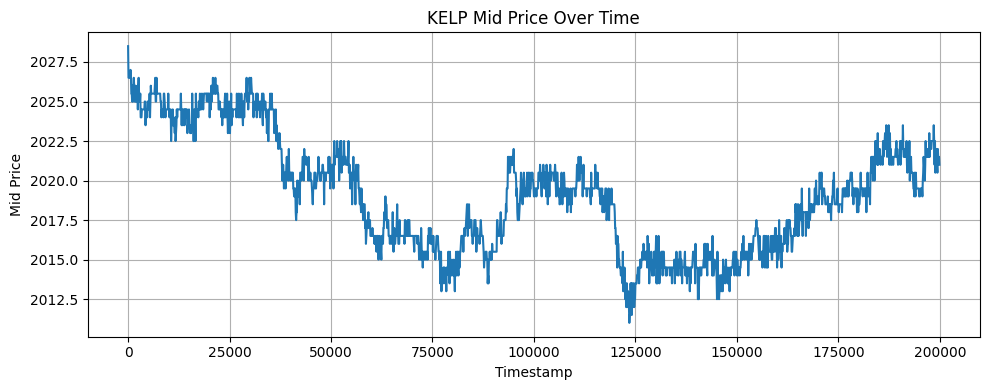

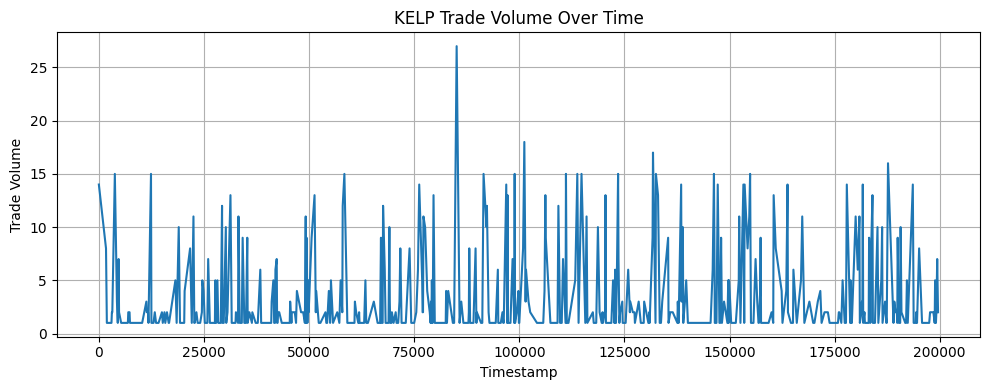

(count    2000.000000
 mean     2019.052000
 std         3.616364
 min      2011.000000
 25%      2016.000000
 50%      2019.000000
 75%      2021.500000
 max      2028.500000
 Name: mid_price, dtype: float64,
 count     607.000000
 mean     2018.484349
 std         3.881411
 min      2010.000000
 25%      2015.000000
 50%      2018.000000
 75%      2022.000000
 max      2029.000000
 Name: price, dtype: float64)

In [4]:
import pandas as pd

# Load the parsed data from previous step
prices_df = prices_df
trades_df = trades_df

# Filter for KELP only
kelp_prices = prices_df[prices_df['product'] == 'KELP'].copy()
kelp_trades = trades_df[trades_df['symbol'] == 'KELP'].copy()

# Compute basic stats
kelp_price_stats = kelp_prices['mid_price'].describe()
kelp_trade_stats = kelp_trades['price'].describe()

# Volume over time
kelp_trades['abs_quantity'] = kelp_trades['quantity'].abs()
kelp_volume_by_time = kelp_trades.groupby('timestamp')['abs_quantity'].sum()

import matplotlib.pyplot as plt

# Plotting mid price
plt.figure(figsize=(10, 4))
plt.plot(kelp_prices['timestamp'], kelp_prices['mid_price'])
plt.title("KELP Mid Price Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting trade volume
plt.figure(figsize=(10, 4))
plt.plot(kelp_volume_by_time.index, kelp_volume_by_time.values)
plt.title("KELP Trade Volume Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Trade Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

kelp_price_stats, kelp_trade_stats


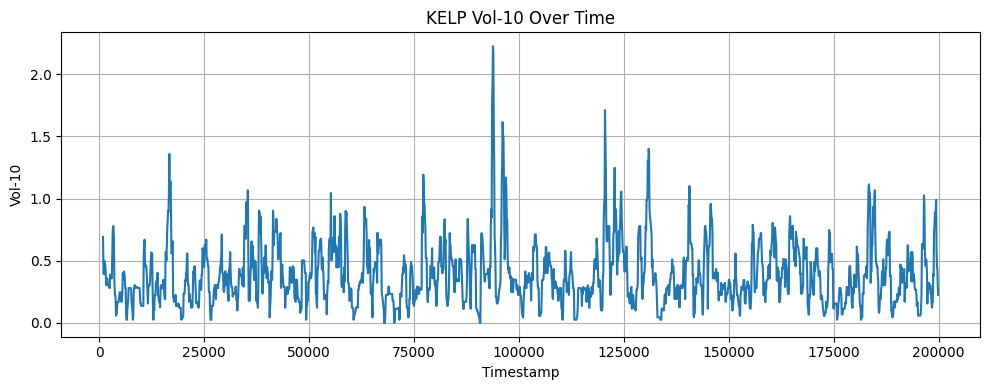

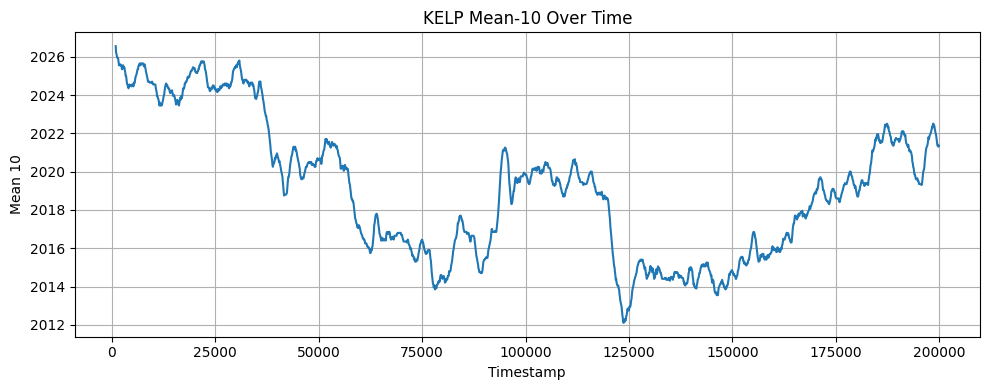

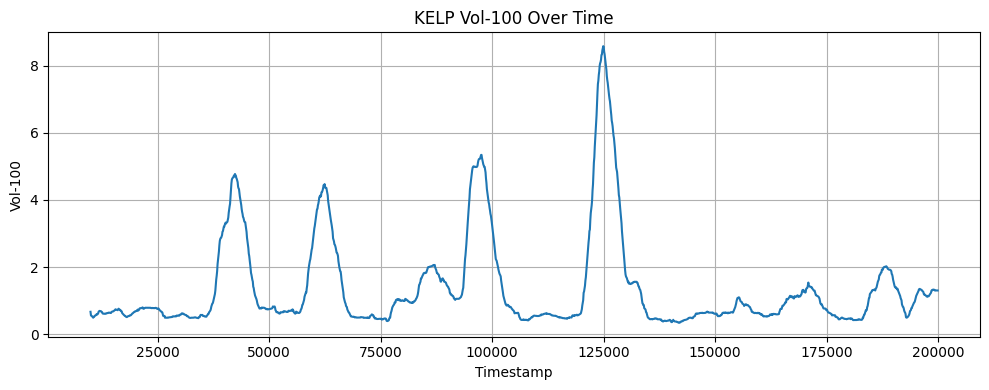

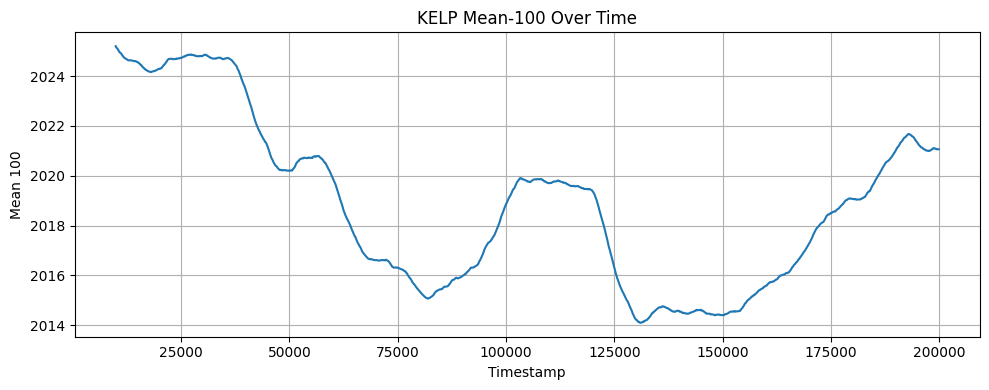

In [7]:
# Compute rolling statistics for KELP mid prices

# Rolling window of 10 timestamps
kelp_prices['rolling_std_10'] = kelp_prices['mid_price'].rolling(window=10).std()**2
kelp_prices['rolling_mean_10'] = kelp_prices['mid_price'].rolling(window=10).mean()

# Rolling window of 100 timestamps
kelp_prices['rolling_std_100'] = kelp_prices['mid_price'].rolling(window=100).std()**2
kelp_prices['rolling_mean_100'] = kelp_prices['mid_price'].rolling(window=100).mean()

# Display the last few rows to confirm calculation
kelp_prices[['timestamp', 'mid_price', 'rolling_std_10', 'rolling_mean_10', 'rolling_std_100', 'rolling_mean_100']].tail()

plt.figure(figsize=(10, 4))
plt.plot(kelp_prices['timestamp'], kelp_prices['rolling_std_10'])
plt.title("KELP Vol-10 Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Vol-10")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(kelp_prices['timestamp'], kelp_prices['rolling_mean_10'])
plt.title("KELP Mean-10 Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Mean 10")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(kelp_prices['timestamp'], kelp_prices['rolling_std_100'])
plt.title("KELP Vol-100 Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Vol-100")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(kelp_prices['timestamp'], kelp_prices['rolling_mean_100'])
plt.title("KELP Mean-100 Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Mean 100")
plt.grid(True)
plt.tight_layout()
plt.show()


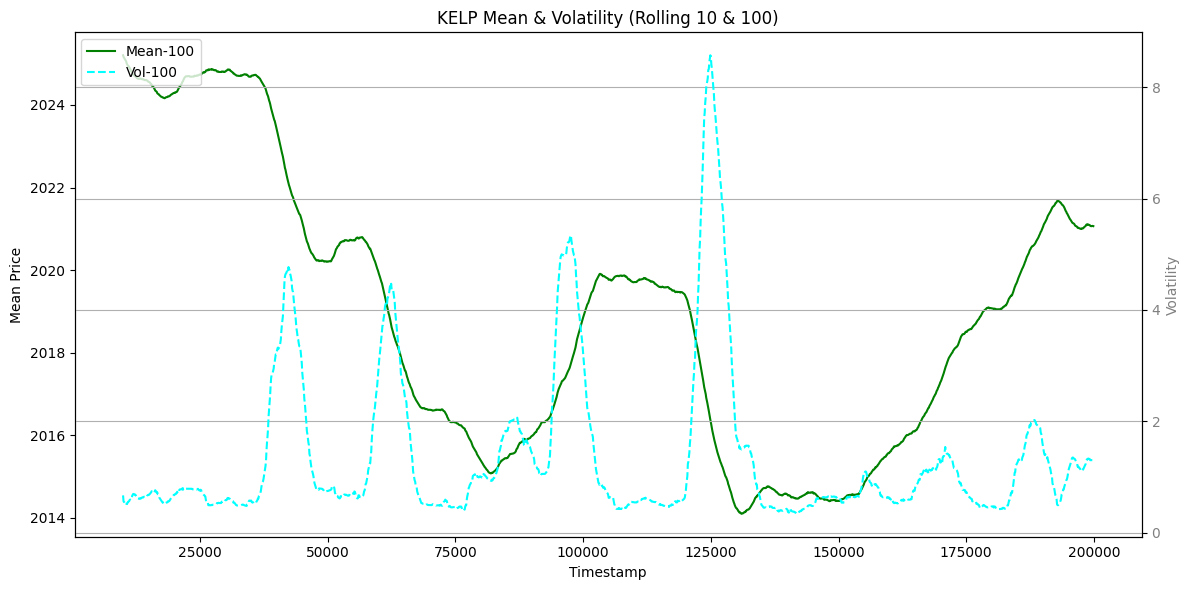

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot means on left y-axis
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Mean Price", color='black')
#ax1.plot(kelp_prices['timestamp'], kelp_prices['rolling_mean_10'], label='Mean-10', color='orange')
ax1.plot(kelp_prices['timestamp'], kelp_prices['rolling_mean_100'], label='Mean-100', color='green')
ax1.tick_params(axis='y', labelcolor='black')

# Second y-axis for volatility
ax2 = ax1.twinx()
ax2.set_ylabel("Volatility", color='gray')
#ax2.plot(kelp_prices['timestamp'], kelp_prices['rolling_std_10'], label='Vol-10', color='blue', linestyle='dashed')
ax2.plot(kelp_prices['timestamp'], kelp_prices['rolling_std_100'], label='Vol-100', color='cyan', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("KELP Mean & Volatility (Rolling 10 & 100)")
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting ARIMA on rolling_mean_10...
Fitting GARCH on rolling_std_10...


/Users/shivmehta/Desktop/Stuff/Productivity/IMC-Prosperity/Tutorial/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/shivmehta/Desktop/Stuff/Productivity/IMC-Prosperity/Tutorial/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/shivmehta/Desktop/Stuff/Productivity/IMC-Prosperity/Tutorial/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.


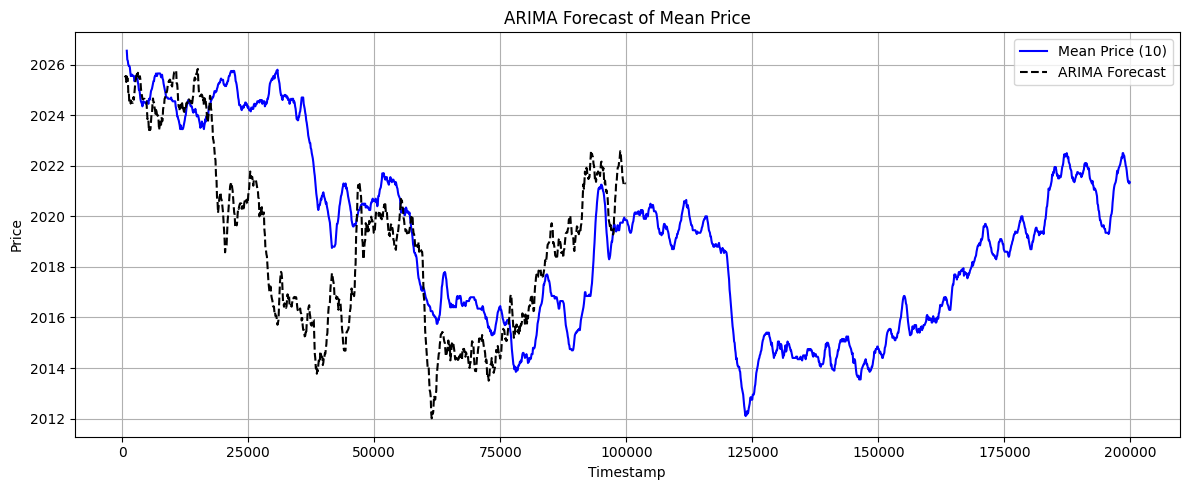

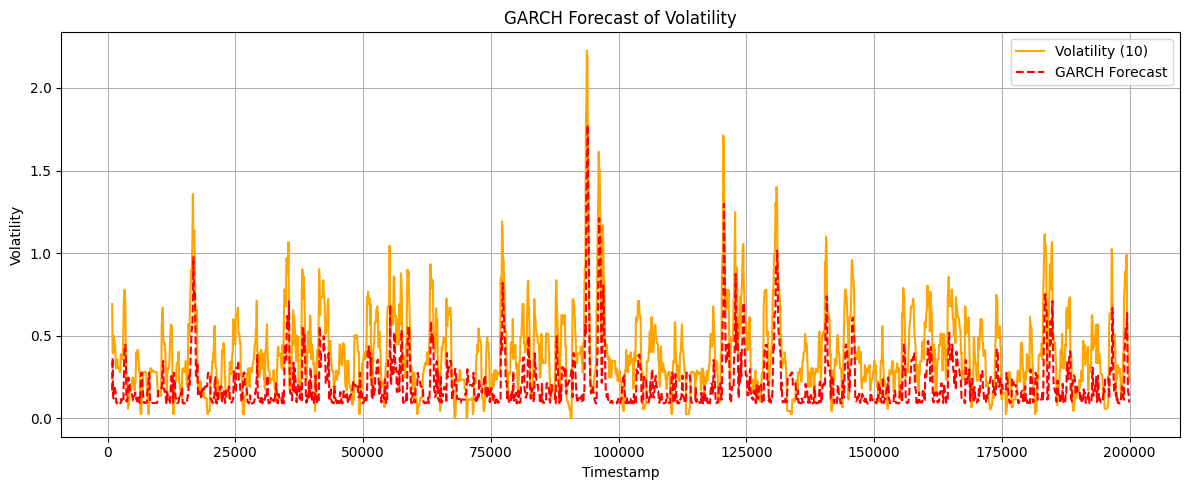

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# === Load your CSVs ===
prices_df = pd.read_csv("../data/Round 0 Day -2 Prices (1).csv", sep=";")
trades_df = pd.read_csv("../data/Round 0 Day -2 Trades (1).csv", sep=";")

# === Preprocessing for KELP ===
kelp_prices = prices_df[prices_df['product'] == 'KELP'].copy()
kelp_prices['timestamp'] = pd.to_numeric(kelp_prices['timestamp'], errors='coerce')

# === Compute rolling volatility (std^2) and mean ===
kelp_prices['rolling_std_10'] = kelp_prices['mid_price'].rolling(window=10).std() ** 2
kelp_prices['rolling_mean_10'] = kelp_prices['mid_price'].rolling(window=10).mean()

# === Use ARIMA to model price ===
print("Fitting ARIMA on rolling_mean_10...")
arima_model = ARIMA(kelp_prices['rolling_mean_10'].dropna(), order=(1, 1, 1))
arima_result = arima_model.fit()
kelp_prices['arima_pred'] = arima_result.predict(start=10, end=len(kelp_prices)-1)

# === Use GARCH to model volatility ===
print("Fitting GARCH on rolling_std_10...")
garch_series = kelp_prices['rolling_std_10'].dropna() 
garch_model = arch_model(garch_series, vol='GARCH', p=10, q=2)
garch_result = garch_model.fit(disp="off")
kelp_prices.loc[garch_series.index, 'garch_pred'] = garch_result.conditional_volatility

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.plot(kelp_prices['timestamp'], kelp_prices['rolling_mean_10'], label='Mean Price (10)', color='blue')
plt.plot(kelp_prices['timestamp'], kelp_prices['arima_pred'], label='ARIMA Forecast', linestyle='--', color='black')
plt.title("ARIMA Forecast of Mean Price")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(kelp_prices['timestamp'], kelp_prices['rolling_std_10'], label='Volatility (10)', color='orange')
plt.plot(kelp_prices['timestamp'], kelp_prices['garch_pred'], label='GARCH Forecast', linestyle='--', color='red')
plt.title("GARCH Forecast of Volatility")
plt.xlabel("Timestamp")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



✅ Heston parameters fitted:
  kappa (mean reversion speed): 2.0000
  theta (long-term vol level):  0.0200
  xi (vol of vol):              0.1000
  rho (correlation):            -0.5000
  v0 (initial variance):        0.0200


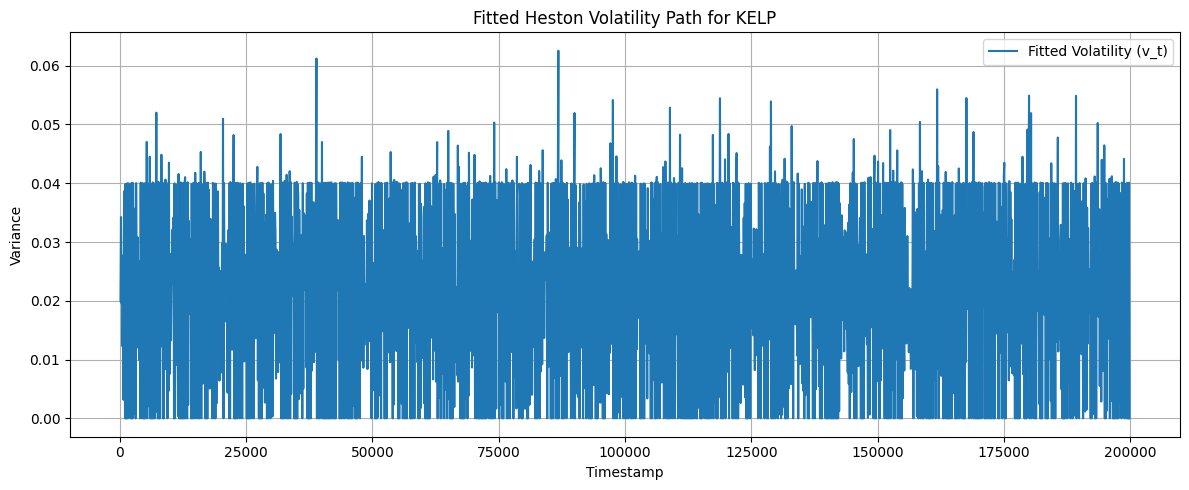

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Load Data ===
df = pd.read_csv("../data/Round 0 Day -2 Prices (1).csv", sep=";")
kelp_df = df[df['product'] == 'KELP'].copy()
kelp_df['timestamp'] = pd.to_numeric(kelp_df['timestamp'], errors='coerce')
kelp_df.sort_values('timestamp', inplace=True)
kelp_df.reset_index(drop=True, inplace=True)

# === Prepare log returns ===
kelp_df['log_price'] = np.log(kelp_df['mid_price'])
kelp_df['log_return'] = kelp_df['log_price'].diff()

# Only drop NaNs from 'log_return' safely
kelp_df = kelp_df.dropna(subset=['log_return'])
returns = kelp_df['log_return'].values

# Ensure it's not empty
if len(returns) == 0:
    raise ValueError("⚠️ Log return series is empty. Check data preprocessing.")

returns = kelp_df['log_return'].values
dt = 1  # assume equal spacing of 1 unit time

# === Heston Log-Likelihood Function ===
def heston_loglik(params, returns, dt):
    kappa, theta, xi, rho, v0 = params
    n = len(returns)
    
    log_likelihood = 0
    vt = v0
    
    for i in range(1, n):
        # Euler discretization of v_t and return
        drift = -0.5 * vt
        diffusion = np.sqrt(vt)
        residual = returns[i] - drift * dt
        variance = vt * dt
        
        if variance <= 0:
            return 1e10

        log_likelihood += -0.5 * (np.log(2 * np.pi * variance) + (residual ** 2) / variance)

        # Update v_t using Euler discretization of Heston volatility process
        dv = kappa * (theta - vt) * dt + xi * np.sqrt(vt * dt) * np.random.normal()
        vt += dv
        vt = max(vt, 1e-6)

    return -log_likelihood

# === Initial Parameters ===
init_params = [2.0, 0.02, 0.1, -0.5, 0.02]  # [kappa, theta, xi, rho, v0]
bounds = [(0.01, 5), (1e-5, 1), (1e-5, 2), (-0.99, 0.99), (1e-5, 1)]

# === Fit the Heston Model ===
result = minimize(heston_loglik, init_params, args=(returns, dt), bounds=bounds)

if result.success:
    kappa, theta, xi, rho, v0 = result.x
    print("\n✅ Heston parameters fitted:")
    print(f"  kappa (mean reversion speed): {kappa:.4f}")
    print(f"  theta (long-term vol level):  {theta:.4f}")
    print(f"  xi (vol of vol):              {xi:.4f}")
    print(f"  rho (correlation):            {rho:.4f}")
    print(f"  v0 (initial variance):        {v0:.4f}")
else:
    print("❌ Optimization failed:", result.message)

# === Simulate Fitted Volatility Path ===
T = len(returns)
vt_path = np.zeros(T)
vt_path[0] = v0

for t in range(1, T):
    dv = kappa * (theta - vt_path[t-1]) * dt + xi * np.sqrt(vt_path[t-1] * dt) * np.random.normal()
    vt_path[t] = max(vt_path[t-1] + dv, 1e-6)

# === Plot Results ===
plt.figure(figsize=(12, 5))
plt.plot(kelp_df['timestamp'].values[:T], vt_path, label='Fitted Volatility (v_t)')
plt.title("Fitted Heston Volatility Path for KELP")
plt.xlabel("Timestamp")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

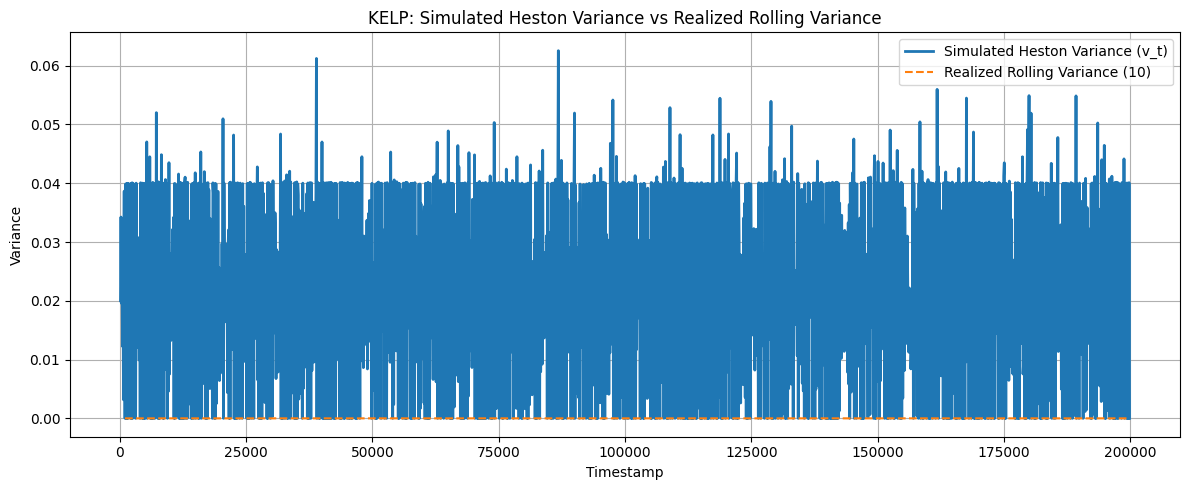

In [26]:
import matplotlib.pyplot as plt

# Ensure kelp_df is aligned with vt_path
kelp_df_trimmed = kelp_df.iloc[:len(vt_path)].copy()

# Realized rolling variance (squared std) over 10-timestamp window
kelp_df_trimmed['realized_var_10'] = kelp_df_trimmed['log_return'].rolling(window=10).var()

# Plot: Simulated Heston volatility vs Actual rolling variance
plt.figure(figsize=(12, 5))
plt.plot(kelp_df_trimmed['timestamp'], vt_path, label='Simulated Heston Variance (v_t)', linewidth=2)
plt.plot(kelp_df_trimmed['timestamp'], kelp_df_trimmed['realized_var_10'], label='Realized Rolling Variance (10)', linewidth=1.5, linestyle='--')
plt.title("KELP: Simulated Heston Variance vs Realized Rolling Variance")
plt.xlabel("Timestamp")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


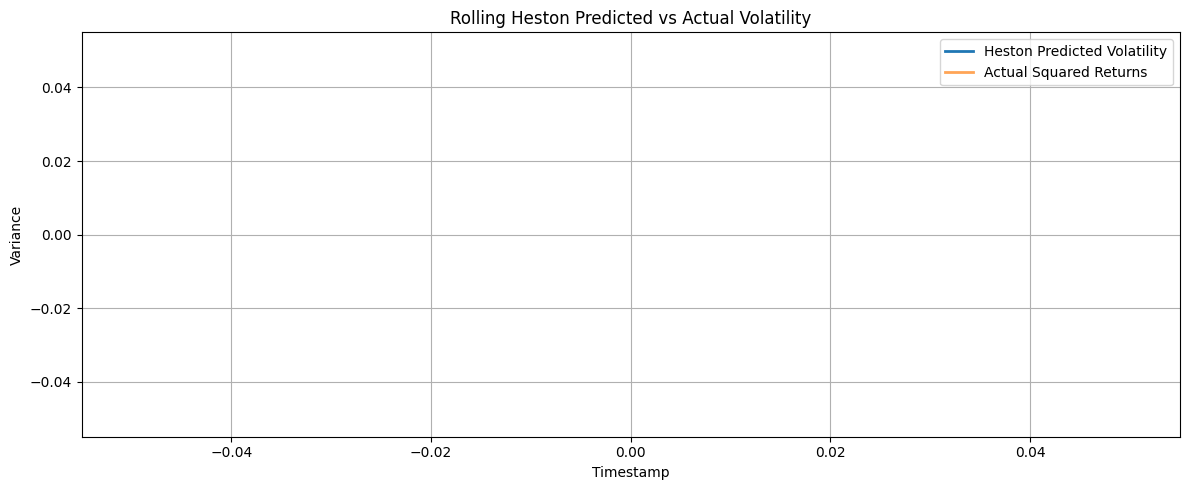

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Load the cleaned data ===
kelp_df = kelp_df.copy()
kelp_df['log_price'] = np.log(kelp_df['mid_price'])
kelp_df['log_return'] = kelp_df['log_price'].diff()
kelp_df.dropna(inplace=True)

returns = kelp_df['log_return'].values
timestamps = kelp_df['timestamp'].values
dt = 1  # Time interval between prices

# === Heston Log-Likelihood Function ===
def heston_loglik(params, returns, dt):
    kappa, theta, xi, rho, v0 = params
    n = len(returns)
    log_likelihood = 0
    vt = v0
    for i in range(1, n):
        drift = -0.5 * vt
        variance = vt * dt
        residual = returns[i] - drift * dt

        if variance <= 0:
            return 1e10

        log_likelihood += -0.5 * (np.log(2 * np.pi * variance) + (residual ** 2) / variance)
        dv = kappa * (theta - vt) * dt + xi * np.sqrt(vt * dt) * np.random.normal()
        vt = max(vt + dv, 1e-6)
    return -log_likelihood

# === Initial Params and Bounds ===
init_params = [2.0, 0.02, 0.1, -0.5, 0.02]
bounds = [(0.01, 5), (1e-5, 1), (1e-5, 2), (-0.99, 0.99), (1e-5, 1)]

# === Rolling Heston Prediction ===
rolling_preds = []
rolling_actuals = []
rolling_timestamps = []

for i in range(10, len(returns) - 1):
    window_returns = returns[i-10:i]
    true_return = returns[i]

    result = minimize(heston_loglik, init_params, args=(window_returns, dt), bounds=bounds, method="L-BFGS-B")
    if result.success:
        kappa, theta, xi, rho, v0 = result.x
        v_pred = v0 + kappa * (theta - v0) * dt
        rolling_preds.append(v_pred)
        rolling_actuals.append(true_return**2)
        rolling_timestamps.append(timestamps[i+1])  # Corrected to align with the predicted point


plt.figure(figsize=(12, 5))
plt.plot(rolling_timestamps, rolling_preds, label="Heston Predicted Volatility", linewidth=2)
plt.plot(rolling_timestamps, rolling_actuals, label="Actual Squared Returns", linewidth=2, alpha=0.7)
plt.title("Rolling Heston Predicted vs Actual Volatility")
plt.xlabel("Timestamp")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


"""
1) Load the CSV data.
2) Filter only rows related to KELP.
3) Compute log returns.
4) Fit GARCH(1,1) model for volatility.
5) Forecast next-step volatility.
6) (Optional) Raise an alert if vol is above a threshold.
7) Visualize price and returns (optional).
"""

# -------------------------
# 1. Load CSV data
# -------------------------
df = pd.read_csv("../data/Round 0 Day -2 Prices (1).csv", sep=";")
df_kelp = df[df['product'] == 'KELP'].copy()

# If needed, convert 'timestamp' to datetime and sort by time
df_kelp['timestamp'] = pd.to_datetime(df_kelp['timestamp'])
df_kelp.sort_values('timestamp', inplace=True)
df_kelp.set_index('timestamp', inplace=True)

# -------------------------
# 3. Compute log returns
# -------------------------
# We'll assume there's a 'price' column for KELP
df_kelp['log_return'] = np.log(df_kelp['price']).diff()
df_kelp.dropna(inplace=True)  # drop first NaN from diff

# -------------------------
# 4. Fit GARCH(1,1) Model
# -------------------------
# We'll model the 'log_return' series
returns = df_kelp['log_return']

# Create GARCH(1,1)
garch_model = arch_model(returns, p=1, q=1, mean='Constant', vol='GARCH', dist='normal')
garch_res = garch_model.fit(disp='off')
print(garch_res.summary())

# -------------------------
# 5. Forecast next-step volatility
# -------------------------
forecast_horizon = 1  # e.g., 1 day ahead
garch_forecast = garch_res.forecast(horizon=forecast_horizon)

# Extract predicted variance for the next period
var_forecast = garch_forecast.variance.iloc[-1]  # last row
# Standard deviation (volatility)
vol_forecast = np.sqrt(var_forecast)

print("\nNext-step forecasted volatility (std dev):")
print(vol_forecast.values[0])  # Should be a single value for GARCH(1,1)

# -------------------------
# 6. (Optional) Raise an alert if vol is high
# -------------------------
# We can compare the forecast to a historical threshold 
# (e.g. the 95th percentile of historical realized vol)

historical_vol = garch_res.conditional_volatility  # Model's in-sample vol estimates
vol_95th = np.percentile(historical_vol.dropna(), 95)

if vol_forecast.values[0] > vol_95th:
    print("ALERT: Elevated volatility forecast for KELP! Potential large price move.")
else:
    print("Forecasted KELP volatility is within normal range.")

# -------------------------
# 7. (Optional) Visualize KELP Price & Returns
# -------------------------
# 7a. Plot the KELP price over time (single figure)
plt.figure()
plt.plot(df_kelp.index, df_kelp['price'])
plt.title("KELP Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# 7b. Plot KELP returns over time (another single figure)
plt.figure()
plt.plot(df_kelp.index, df_kelp['log_return'])
plt.title("KELP Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

KeyError: 'price'

In [35]:
import numpy as np
from sklearn.linear_model import LinearRegression

def fit_autoregressive_model(price_series: list[float]):
    if len(price_series) < 20:
        return None  # not enough data

    X = []
    y = []

    for i in range(4, len(price_series)):
        X.append([
            price_series[i-1],
            price_series[i-2],
            price_series[i-3],
            price_series[i-4]
        ])
        y.append(price_series[i])

    model = LinearRegression().fit(X, y)
    coeffs = model.coef_
    intercept = model.intercept_
    score = model.score(X, y)  # R²

    return {
        'a': coeffs[0],
        'b': coeffs[1],
        'c': coeffs[2],
        'd': coeffs[3],
        'e': intercept,
        'r2': score
    }


In [38]:
price_files = [
    "../data_1/prices_round_1_day_-2.csv",
    "../data_1/prices_round_1_day_-1.csv",
    "../data_1/prices_round_1_day_0.csv"
]

# Reload using the correct delimiter
prices = pd.concat([pd.read_csv(file, delimiter=';') for file in price_files])

# Filter only KELP product
kelp_prices = prices[prices['product'] == 'KELP'].copy()

# Sort by timestamp
kelp_prices.sort_values(by='timestamp', inplace=True)

# Reset index
kelp_prices.reset_index(drop=True, inplace=True)

# Recalculate mid_price if necessary
kelp_prices['mid_price'] = (kelp_prices['bid_price_1'] + kelp_prices['ask_price_1']) / 2

In [54]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the mid price data we computed
kelp_mid_prices = kelp_prices['mid_price'].values

# Prepare the lagged dataset for autoregression
def create_lagged_dataset(series, lags=5):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i-lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Create features and target
X, y = create_lagged_dataset(kelp_mid_prices, lags=5)

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict and evaluate
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

coefficients, intercept, mse

(array([ 0.19786152,  0.26630769,  0.48103061, -0.03572424, -0.33986252]),
 np.float64(870.8792804742575),
 83.15613809195133)

In [55]:
import pandas as pd

# Recreate X_with_intercept for prediction
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
y_pred = X_with_intercept @ coefficients

# Create a DataFrame comparing predicted and actual prices
comparison_df = pd.DataFrame({
    'Actual Price': y.values,
    'Predicted Price': y_pred
})

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 6)

In [56]:
# Filter for KELP product
kelp_prices = prices[prices["product"] == "KELP"].copy()

# Compute mid-price
kelp_prices["mid_price"] = (kelp_prices["bid_price_1"] + kelp_prices["ask_price_1"]) / 2

# Create order flow signals
kelp_prices["bid_ask_spread"] = kelp_prices["ask_price_1"] - kelp_prices["bid_price_1"]
kelp_prices["order_flow_imbalance"] = (kelp_prices["bid_volume_1"] - kelp_prices["ask_volume_1"]) / (
    kelp_prices["bid_volume_1"] + kelp_prices["ask_volume_1"]
)

# Drop rows with NaNs
kelp_prices.dropna(subset=["mid_price", "bid_ask_spread", "order_flow_imbalance"], inplace=True)

# Function to create lagged dataset
def create_lagged_features(series, lags, additional_features=None):
    X, y = [], []
    for i in range(lags, len(series)):
        row = list(series[i-lags:i])
        if additional_features is not None:
            row.extend(additional_features[i])
        X.append(row)
        y.append(series[i])
    return np.array(X), np.array(y)

# Extract target and additional features
mid_prices = kelp_prices["mid_price"].values
additional_features = kelp_prices[["bid_ask_spread", "order_flow_imbalance"]].values

# Grid search for best lag
results = []
for lag in range(1, 11):
    X, y = create_lagged_features(mid_prices, lags=lag, additional_features=additional_features)
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    results.append((lag, mse, model.coef_, model.intercept_))

# Present results
results_df = pd.DataFrame(results, columns=["lags", "mse", "coefficients", "intercept"])


In [58]:
results_df

,lags,mse,coefficients,intercept
0,1,0.413127,"[0.9970398834098545, 0.025701453240555755, -0....",5.944136
1,2,0.273475,"[0.4785021752223576, 0.5197366661660103, 0.027...",3.514296
2,3,0.233125,"[0.2926020233220396, 0.3257931136035803, 0.380...",2.786581
3,4,0.215004,"[0.20460938249804575, 0.2135804798295451, 0.25...",2.435686
4,5,0.205532,"[0.15118617153547662, 0.15507352341981973, 0.1...",2.246613
5,6,0.200261,"[0.11399483501155204, 0.11724359371051374, 0.1...",2.130515
6,7,0.197252,"[0.08665971056424887, 0.08955859904643376, 0.0...",2.064035
7,8,0.196245,"[0.050413415421969844, 0.07292492481099122, 0....",2.033774
8,9,0.195466,"[0.04446304187485909, 0.03845050080660051, 0.0...",2.005058
9,10,0.194944,"[0.035971197910642634, 0.03479178330711119, 0....",1.992699


In [60]:
RMSE = np.sqrt(results_df['mse'])
RMSE

0    0.642750
1    0.522949
2    0.482830
3    0.463685
4    0.453357
5    0.447505
6    0.444131
7    0.442996
8    0.442115
9    0.441525
Name: mse, dtype: float64

In [63]:
import numpy as np
import pandas as pd

# Recreate the results_df from the user’s provided code
kelp_prices = kelp_prices.copy()
mid_prices = kelp_prices["mid_price"].values
additional_features = kelp_prices[["bid_ask_spread", "order_flow_imbalance"]].values

# Function to create lagged dataset
def create_lagged_features(series, lags, additional_features=None):
    X, y = [], []
    for i in range(lags, len(series)):
        row = list(series[i-lags:i])
        if additional_features is not None:
            row.extend(additional_features[i])
        X.append(row)
        y.append(series[i])
    return np.array(X), np.array(y)

# Compute directional accuracy and add it to results
directional_results = []
for lag in range(1, 11):
    X, y = create_lagged_features(mid_prices, lags=lag, additional_features=additional_features)
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)

    # Compute directional accuracy
    predicted_direction = np.sign(predictions[1:] - predictions[:-1])
    actual_direction = np.sign(y[1:] - y[:-1])
    directional_accuracy = np.mean(predicted_direction == actual_direction)

    directional_results.append((lag, mse, directional_accuracy, model.coef_, model.intercept_))

# Create DataFrame to show results
directional_results_df = pd.DataFrame(directional_results, columns=["lags", "mse", "directional_accuracy", "coefficients", "intercept"])

directional_results_df['RMSE'] = np.sqrt(directional_results_df['mse'])

directional_results_df

,lags,mse,directional_accuracy,coefficients,intercept,RMSE
0,1,0.413127,0.474798,"[0.9970398834098545, 0.025701453240555755, -0....",5.944136,0.642750
1,2,0.273475,0.531520,"[0.4785021752223576, 0.5197366661660103, 0.027...",3.514296,0.522949
2,3,0.233125,0.543906,"[0.2926020233220396, 0.3257931136035803, 0.380...",2.786581,0.482830
3,4,0.215004,0.542557,"[0.20460938249804575, 0.2135804798295451, 0.25...",2.435686,0.463685
4,5,0.205532,0.537741,"[0.15118617153547662, 0.15507352341981973, 0.1...",2.246613,0.453357
5,6,0.200261,0.533958,"[0.11399483501155204, 0.11724359371051374, 0.1...",2.130515,0.447505
6,7,0.197252,0.531542,"[0.08665971056424887, 0.08955859904643376, 0.0...",2.064035,0.444131
7,8,0.196245,0.529826,"[0.050413415421969844, 0.07292492481099122, 0....",2.033774,0.442996
8,9,0.195466,0.528943,"[0.04446304187485909, 0.03845050080660051, 0.0...",2.005058,0.442115
9,10,0.194944,0.529161,"[0.035971197910642634, 0.03479178330711119, 0....",1.992699,0.441525


In [65]:
directional_results_df['coefficients'][4]

array([ 0.15118617,  0.15507352,  0.17414473,  0.22756946,  0.29089259,
        0.02699926, -0.8650637 ])

In [66]:
directional_results_df['intercept'][4]

np.float64(2.2466130269906444)